In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

In [10]:
np.random.seed(42)

# parameters
m_train = 1000
m_test = 5000

mu_plus = np.array([0., 2.])
mu_minus = np.array([0., -2.])
Sigma = np.array([[1.5, 0.0],
                  [0.0, 1.5]])

n_train_per_class = m_train // 2
n_test_per_class = m_test // 2

# training sample
X_train_pos = np.random.multivariate_normal(mu_plus, Sigma, size=n_train_per_class)
X_train_neg = np.random.multivariate_normal(mu_minus, Sigma, size=n_train_per_class)

y_train_pos = np.ones(n_train_per_class, dtype=int)      # +1
y_train_neg = -np.ones(n_train_per_class, dtype=int)     # -1

X_train = np.vstack([X_train_pos, X_train_neg])
y_train = np.concatenate([y_train_pos, y_train_neg])

# test sample
X_test_pos = np.random.multivariate_normal(mu_plus, Sigma, size=n_test_per_class)
X_test_neg = np.random.multivariate_normal(mu_minus, Sigma, size=n_test_per_class)

y_test_pos = np.ones(n_test_per_class, dtype=int)
y_test_neg = -np.ones(n_test_per_class, dtype=int)

X_test = np.vstack([X_test_pos, X_test_neg])
y_test = np.concatenate([y_test_pos, y_test_neg])

# samples' permutation
perm_train = np.random.permutation(m_train)
X_train = X_train[perm_train]
y_train = y_train[perm_train]

perm_test = np.random.permutation(m_test)
X_test = X_test[perm_test]
y_test = y_test[perm_test]

X_train.shape, X_test.shape


((1000, 2), (5000, 2))

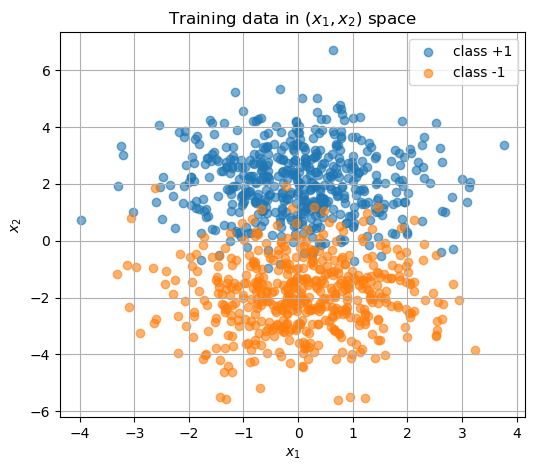

In [72]:
plt.figure(figsize=(6, 5))
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], alpha=0.6, label='class +1')
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], alpha=0.6, label='class -1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Training data in $(x_1, x_2)$ space')
plt.legend()
plt.grid(True)
plt.savefig("training_data_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

## Training Data Distribution

The training dataset consists of two balanced classes generated from bivariate Gaussian distributions with identical covariance matrices but different means.

- Class **+1**: centered at $(0, 2)$  
- Class **–1**: centered at $(0, -2)$  
- Covariance matrix:  
  \[
  \begin{pmatrix} 1.5 & 0 \\ 0 & 1.5 \end{pmatrix}
  \]

Because both classes have substantial variance, their distributions overlap in the region around $x_2 \approx 0$. This overlap makes perfect separation impossible and determines the intrinsic Bayes error of the problem.

The scatter plot visualizes this structure: two vertically separated clusters with a non-separable middle region where points from both classes coexist.

In [22]:
ks = [1, 3, 5, 11, 31, 101]

bayes_risks = []
clf_errors = []

# labels to {0,1} for calculation of the probability of class 1 (estimated conditional probability)
y_train01 = (y_train == 1).astype(int)
y_test01 = (y_test == 1).astype(int)

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train01)
    
    # estimation eta_hat(x) for test: P_hat(Y=1 | X=x)
    eta_hat_test = knn.predict_proba(X_test)[:, 1]

    # Bayes risk
    R_bayes_hat = np.mean(np.minimum(eta_hat_test, 1 - eta_hat_test))
    bayes_risks.append(R_bayes_hat)

    # k-NN classifier and its error
    y_pred01 = (eta_hat_test >= 0.5).astype(int)
    y_pred_pm1 = np.where(y_pred01 == 1, 1, -1)
    
    R_clf_hat = np.mean(y_pred_pm1 != y_test)
    clf_errors.append(R_clf_hat)

bayes_risks, clf_errors

([0.0,
  0.04306666666666666,
  0.04944,
  0.05281818181818181,
  0.05705806451612903,
  0.06666138613861386],
 [0.0796, 0.0582, 0.0562, 0.0522, 0.0514, 0.0494])

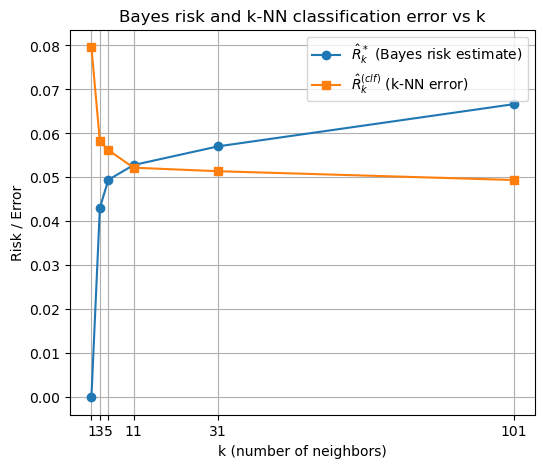

In [74]:
plt.figure(figsize=(6, 5))
plt.plot(ks, bayes_risks, marker='o', label=r'$\hat{R}^*_k$ (Bayes risk estimate)')
plt.plot(ks, clf_errors, marker='s', label=r'$\hat{R}^{(clf)}_k$ (k-NN error)')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Risk / Error')
plt.title('Bayes risk and k-NN classification error vs k')
plt.xticks(ks)
plt.grid(True)
plt.legend()
plt.savefig("risk_curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [70]:
plt.savefig("risk_curve.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Bayes Risk and k-NN Classification Error as Functions of k

The plot displays two curves:

- $\hat{R}^*_k$ — estimated **Bayes risk** (irreducible error),
- $\hat{R}^{(clf)}_k$ — test error of the **k-NN classifier**.

### Key observations:

### **1. Very small k (e.g., k = 1) leads to overfitting**
- The classifier has extremely high variance.
- $\hat{R}^{(clf)}_1$ is much larger than for other values of k.

### **2. Increasing k reduces variance**
As k grows from 1 to 11:
- classification error drops sharply,
- probability estimates $\hat{\eta}_k(x)$ become smoother,
- Bayes risk estimates stabilize.

### **3. Large k gives smoother but more biased estimates**
For $k = 31$ and $k = 101$:
- the curves flatten,
- classification error stabilizes around ~0.05,
- Bayes risk estimate slowly increases due to increased bias.

### **4. Bayes risk is always below the classifier error**
This matches theory, because no classifier can beat the Bayes classifier.

Thus, the plot clearly demonstrates the bias–variance trade-off inherent in k-NN.

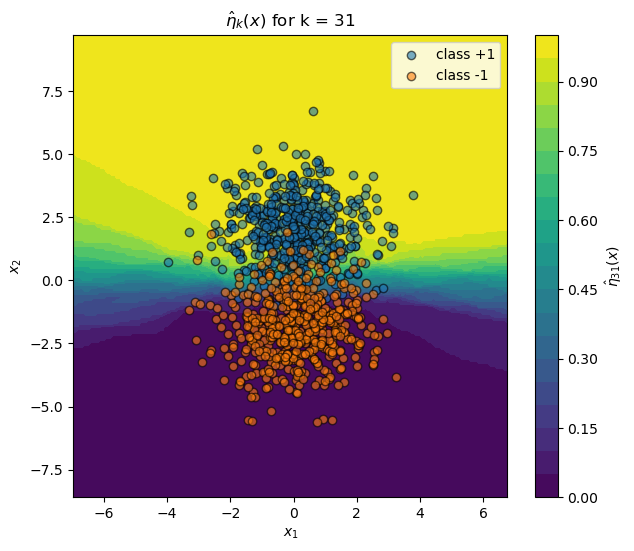

In [76]:
k_vis = 31
knn_vis = KNeighborsClassifier(n_neighbors=k_vis)
knn_vis.fit(X_train, y_train01)

# grid for x1, x2
x1_min, x1_max = X_train[:, 0].min() - 3, X_train[:, 0].max() + 3
x2_min, x2_max = X_train[:, 1].min() - 3, X_train[:, 1].max() + 3

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 200),
    np.linspace(x2_min, x2_max, 200)
)

grid_points = np.c_[xx1.ravel(), xx2.ravel()]
eta_hat_grid = knn_vis.predict_proba(grid_points)[:, 1]
eta_hat_grid = eta_hat_grid.reshape(xx1.shape)

plt.figure(figsize=(7, 6))
contour = plt.contourf(xx1, xx2, eta_hat_grid, levels=20)
plt.colorbar(contour, label=r'$\hat{\eta}_{%d}(x)$' % k_vis)

# training points upper
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            edgecolor='k', alpha=0.6, label='class +1')
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1],
            edgecolor='k', alpha=0.6, label='class -1')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title(r'$\hat{\eta}_{k}(x)$ for k = %d' % k_vis)
plt.legend()
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

## Heatmap of $\hat{\eta}_k(x)$ for k = 31

The heatmap visualizes the estimated conditional probability:

\[
$\hat{\eta}_k(x) = P(Y = 1 \mid X = x)
$\]

computed using 31 nearest neighbors.


- **Yellow / light green**: $\hat{\eta}_k(x) \approx 1$  
  → region strongly associated with class +1.

- **Dark blue / purple**: $\hat{\eta}_k(x) \approx 0$  
  → region strongly associated with class –1.

- **Green transition band**: $\hat{\eta}_k(x) \approx 0.5$  
  → this area represents the overlap between class densities.  
    Classification here is inherently ambiguous.

The decision boundary emerges naturally as the level set  
$[$
$\hat{\eta}_k(x) = 0.5.
$\]

For $k=31$, the boundary is smooth due to averaging over many neighbors, which reduces noise in the probability estimate. Training points plotted on top demonstrate how the model aligns with the underlying class structure.

## Conclusion

This experiment illustrates how k-NN can be used both as a classifier and as an estimator of the Bayes risk.

1. **The training data contain unavoidable ambiguity**  
   Overlap between the Gaussian class distributions produces a non-zero Bayes risk.

2. **k-NN with small k heavily overfits**  
   High variance leads to large classification error.

3. **Intermediate k (5–11) produces the best classifier performance**  
   This region balances bias and variance.

4. **Large k yields stable but biased estimates**  
   Both the Bayes risk estimate and classification error converge.

5. **Bayes risk is consistently below the classifier error**  
   As required by statistical learning theory.

### Final takeaway:

k-NN provides a simple yet effective non-parametric method for estimating  
$P(Y = 1 \mid X = x)$, approximating the Bayes decision rule, and empirically evaluating the Bayes risk. The results align closely with theoretical expectations, demonstrating the classic bias–variance behavior of nearest-neighbor methods.
